In [2]:
from brian2 import *
import pandas as pd
import sympy
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import dh_parameters as dp

%matplotlib notebook

from importlib import reload
reload(dp);

In [3]:
p, w_mu, w_sigma = dp.interneuronal_connectivity_tables()

In [3]:
def generate_periodic_spike_times(rate, start_time, stop_time):
    ###unitless but do it in seconds to make it easy
    duration = stop_time - start_time
    num_spikes = np.floor(duration * rate)
    true_duration = num_spikes / rate
    spike_times = np.linspace(start_time, start_time + true_duration, num_spikes)
    return spike_times

def connect_neuron_groups(pre_group, post_group,
                          conductance_name = 'e',
                          p = 1, 
                          w_mu = 1 * nS, 
                          w_sigma = 0.1 * nS):
    on_pre_equation = 'g_' + conductance_name + '_post += w'
    S = Synapses(pre_group, post_group,model = 'w : siemens',
                             on_pre = on_pre_equation)
    S.connect(p = p)
    S.w =  w_mu + w_sigma * randn(S.w.shape[0])
    S.w['w < 0 * nS'] = 0 * nS
    return S

class neuron_group_constructor():
        
    def __init__(self):
        self.params = {}
    
    def select_cell_type(self, cell_type):
        self.params = dp.get_neuron_params(cell_type)
        return self
    
    def return_ta(self):
        N = self.params['N']
        tb = np.arange(0,duration,sim_dt)
        I_ex_mu = self.params['intrinsics']['I_ex_mu']
        I_ex_sigma = self.params['intrinsics']['I_ex_sigma']
        I_ex = (I_ex_mu + I_ex_sigma * randn(N))
        I_ex_array = np.tile(I_ex, (tb.shape[0],1))
        self.I_ex = TimedArray(I_ex_array,sim_dt)
        return I_ex_array
    
    def initialize_external_current_array(self):
        N = self.params['N']
        tb = np.arange(0,duration,sim_dt)
        I_ex_mu = self.params['intrinsics']['I_ex_mu']
        I_ex_sigma = self.params['intrinsics']['I_ex_sigma']
        I_ex = (I_ex_mu + I_ex_sigma * randn(N))
        self.I_ex = np.tile(I_ex, (tb.shape[0],1)) 
        return self

    def generate_neuron_group(self, initialize = True):
        
        N = self.params['N']
        self.initialize_external_current_array()
        
        # create neuron group and add params to namespace
        NG = NeuronGroup(N, model=self.params['model_eq'],
                     threshold=self.params['threshold_eq'],
                     reset=self.params['reset_eq'],
                     refractory=self.params['refractory_eq'],
                     method = 'euler')

        for key, value in self.params['intrinsics'].items():
            NG.namespace[key] = value
  
        # constant parameters that vary between neurons in this group
        g_l_mu = self.params['intrinsics']['g_l_mu']
        g_l_sigma = self.params['intrinsics']['g_l_sigma']
        NG.g_l = (g_l_mu + g_l_sigma * randn(N))
        
        if initialize:
            NG.g_i = '0 * nS'
            NG.g_e = '0 * nS'
            NG.v = self.params['intrinsics']['E_l']   
            if self.params['dynamics'] == 'adex':
                 NG.u = '0 * pA'
        
        return NG, self.params.copy(), self.I_ex
    
    ## projection neurons
    

        
    
def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
        time_bins = np.arange(0,duration,sim_dt)
        mu_ = mu 
        sigma_ = sigma  
        psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
        psth = psth/sum(psth)
        return psth,time_bins

def spikes_from_psth(psth):
    return np.random.binomial(1,psth)

def generate_population_spikes(kernel,rates):
    spikes = []
    ind = []
    for i,r in enumerate(rates):
        this_spikes = np.where(spikes_from_psth(kernel*r))[0]
        this_ind = np.ones(this_spikes.shape) * i
        spikes.append(this_spikes)
        ind.append(this_ind)
    spikes = np.concatenate(spikes) *sim_dt
    ind = np.concatenate(ind).astype(int)
    return spikes, ind
    
class afferent_group():
    
    def __init__(self):
        self.params = {}
        self.time_bins = np.arange(0,duration,sim_dt)
        self.psth = np.zeros(self.time_bins.shape)
        
    def select_cell_type(self, cell_type):
        self.params = dp.get_afferent_params(cell_type)
        return self
        
    def add_stim(self, stim_type, start_time,**kwargs):
        
        if stim_type == 'electrical':
            sigma = self.params['stim_electrical_sigma']
            N = self.params['N']
            rates = self.params['stim_electrical_rates']
            if not isinstance(rates, (list, tuple, np.ndarray)):
                rates = np.ones(N)*rates
            
            stim_response, time_bins = gaussian_psth(start_time + self.params['delay'], sigma)
            self.psth += stim_response
            self.spikes, self.ind = generate_population_spikes(self.psth,rates)
        
    def generate_afferent_group(self):
        return SpikeGeneratorGroup(self.params['N'], self.ind, self.spikes), self.params.copy()
    
    
def initialize_I_ex(NG, I_ex):
    NG.namespace['I_ex'] = TimedArray(I_ex,sim_dt)
    
def add_step(I_ex, start, stop, amplitude):
    tb = np.arange(0,duration,sim_dt)
    window = (tb > start) & (tb < stop)
    I_ex[window,:] = amplitude
    return I_ex       

In [5]:
################################################################################
# Model parameters
################################################################################
### General parameters
duration = 0.3*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
defaultclock.dt = sim_dt

In [9]:
af_cts = ['pep1','pep2','AB_ltmr']
af_ngs = {}
af_params = {}
for ct in af_cts:
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.add_stim('electrical', start_time = 10 * ms)
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()
cts = ['pr_noci','e_vertical','e_grp','i_nnos','e_nts','i_gal','i_pv']
ngs = {}
params = {}
i_ex = {}
for ct in cts:
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()

In [10]:
states={}
spikes = {}
for cell_type in params:
    states[cell_type]= StateMonitor(ngs[cell_type], ['v','g_e','g_i'], record=True)
    spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)

In [11]:
synapses=[]
for pre, outputs in params.items():
    for post in outputs['outputs']:
        if post in params.keys():
            print(pre,post)
            synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

for pre, outputs in af_params.items():
    for post in outputs['outputs']:
        if post in params.keys():
                print(pre,post)
                synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

e_vertical pr_noci
e_grp e_vertical
i_nnos pr_noci
e_nts e_grp
e_nts e_nts
i_gal e_vertical
i_gal e_grp
i_gal e_nts
i_pv e_nts
pep1 pr_noci
pep1 e_vertical
pep1 e_grp
pep1 i_gal
pep1 i_nnos
pep2 pr_noci
pep2 e_vertical
pep2 e_grp
pep2 i_gal
pep2 i_nnos
AB_ltmr e_nts
AB_ltmr i_pv
AB_ltmr i_gal


In [12]:
for ct in cts:
    initialize_I_ex(ngs[ct], i_ex[ct])

In [13]:
net = Network(ngs,states,spikes,synapses,af_ngs)
# net.add()
net.store()

In [ ]:
net.restore()

In [14]:
net.run(duration, report = 'text')

Starting simulation at t=0. s for a duration of 300. ms
0.3 (100%) simulated in 2s


WARNING    /Users/nakaa1/anaconda3/envs/brian/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
 [py.warnings]
WARNING    /Users/nakaa1/anaconda3/envs/brian/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
 [py.warnings]


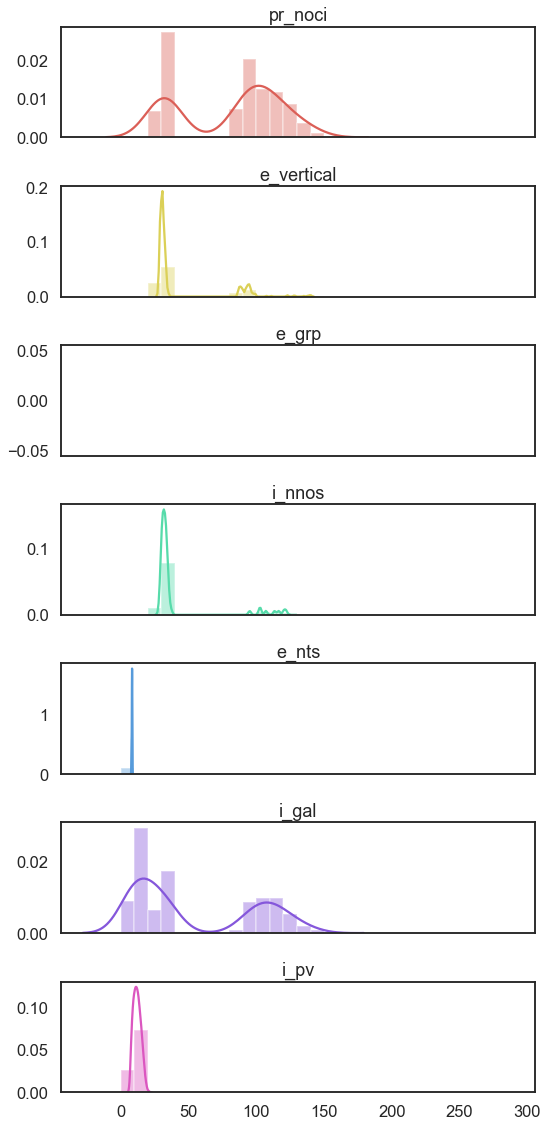

In [36]:
bins = np.arange(0,duration/ms,10)
cmap = sns.color_palette("hls", 7)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[i], bins = bins, color = cmap[i])
    ax[i].set_title(ct)
plt.tight_layout()


In [25]:
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

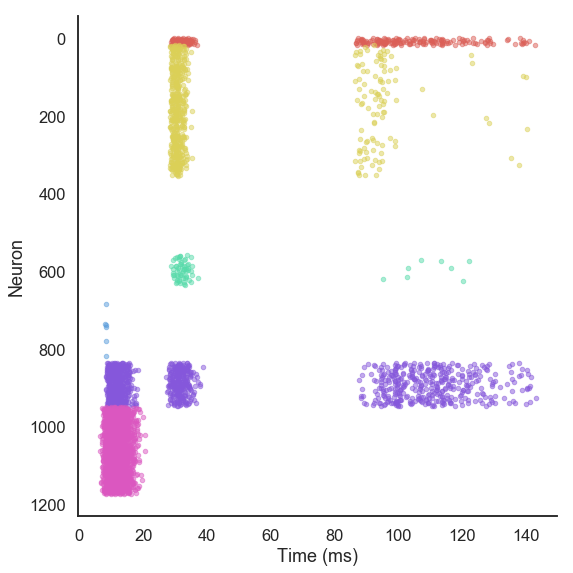

In [37]:
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 0.5);
    y_bias += params[ct]['N']
plt.tight_layout()
sns.despine()
ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (ms)')
f.savefig('/Users/nakaa1/Documents/Presentations/group_meeting_20190329/raster.png',dpi = 300)

<IPython.core.display.Javascript object>


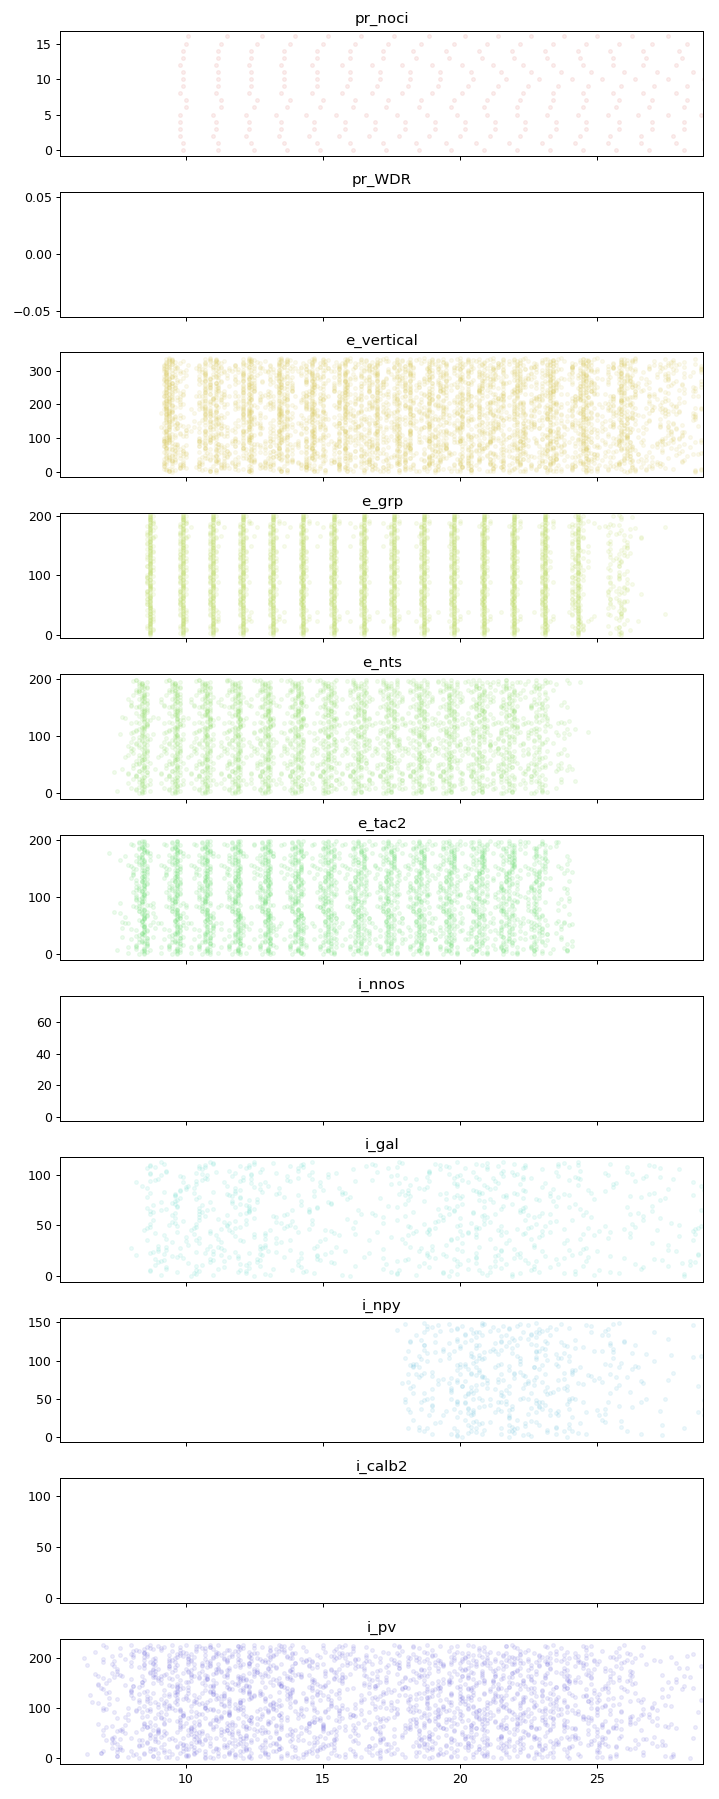

In [110]:
f,ax = plt.subplots(len(spikes),1,figsize = (8,20), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax[i].plot(spike_mon.t/ms, spike_mon.i,'.', color = cmap[i],alpha = 0.1);
    ax[i].set_title(ct)
plt.tight_layout()

In [80]:
state_mon.v_.shape

(17, 6000)

In [30]:
def make_spikes_pretty(spikemon,statemon,spike_height = 0.040):
    inds = spikemon.i
    time_inds = spikemon.t/sim_dt
    time_inds = time_inds.astype(int)
    for i,t in zip(inds,time_inds):
        statemon.v_[i,t] = spike_height

In [44]:
sns.set_context('talk')

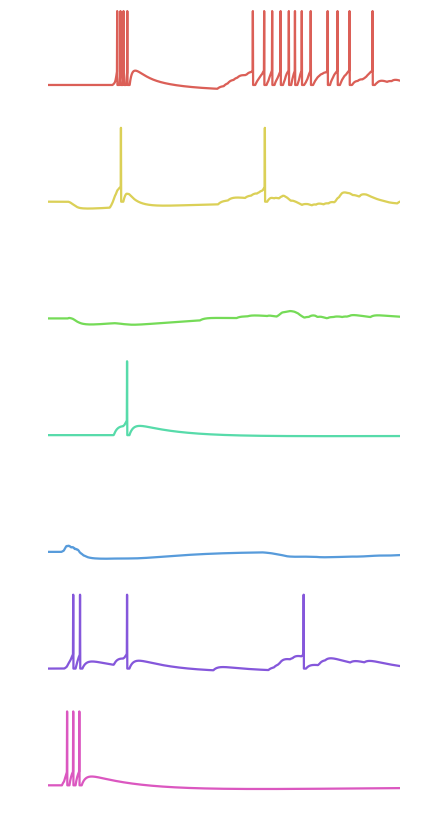

In [54]:
f,ax = plt.subplots(len(states),1,figsize = (6,12), sharex = True,sharey = True)

nts = ['pr_noci','e_vertical','e_nts','i_gal','i_pv']
nts = ['pr_noci','e_vertical','e_grp','i_nnos','e_nts','i_gal','i_pv']
for i,ct in enumerate(nts):
    make_spikes_pretty(spikes[ct],states[ct])
    ax[i].plot(states[ct].t/ms, states[ct].v[0,:]/ms,color = cmap[i]);
#     ax[i].set_ylabel(ct)
    ax[i].axis('off')
    sns.despine()
#     ax[i].set_ylabel('mV')
    
plt.tight_layout()    
ax[-1].set_xlim((0,150))
# ax.set_ylabel('Neuron')
# ax.set_xlabel('Time (ms)')
f.savefig('/Users/nakaa1/Documents/Presentations/group_meeting_20190329/vm.png',dpi = 300)

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,8))
for i,(ct,state_mon) in enumerate(states.items()):
    ax[i].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
# afferent inputs
AB_psth,time_bins = gaussian_psth(mu = 10 * ms, sigma = 1 * ms)
AD_psth,time_bins = gaussian_psth(mu = 20 * ms, sigma = 2 * ms)
C_psth,time_bins = gaussian_psth(mu = 120 * ms, sigma = 20 * ms)

C_spikes, C_ind = generate_population_spikes(C_psth,np.ones(50)*2)
AB_spikes, AB_ind = generate_population_spikes(AB_psth,np.ones(10)*5)
AD_spikes, AD_ind = generate_population_spikes(AD_psth,np.ones(10)*5)
f, ax = plt.subplots(2,1,figsize = (8,8), sharex = True)
ax[0].plot(AB_spikes, AB_ind,'.k')
ax[0].plot(AD_spikes, AD_ind+10,'.b')
ax[0].plot(C_spikes, C_ind+20,'.r')
ax[1].plot(time_bins, AB_psth,'k')
ax[1].plot(time_bins, AD_psth,'b')
ax[1].plot(time_bins, C_psth,'r')

In [ ]:
E_l = -70 * mV
E_e = 0 * mV
E_i = -70 * mV
C_m = 200 * pF
V_th = -40 * mV
V_r = -50 * mV
tau_e = 5 * ms
tau_i = 5 * ms
tau_r = 1 * ms
g_l = 0.5 * nS
I_ex = 20 * pA

In [ ]:
# neuron_eqs = Equations('''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# g_l : siemens (constant)
# E_l : volt (constant)
# E_e : volt (constant)
# E_i : volt (constant)
# I_ex : amp
# C_m : farad (constant)
# tau_i : second (constant)
# tau_e : second (constant)
# ''')

neuron_eqs = Equations('''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
I_ex : amp (constant)
g_l : siemens (constant)
''')

# neuron_eqs = '''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# '''



synapses_eqs = Equations('''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
''')
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''

# maybe could switch to system where each synapse has a reversal potential
# rather than being excitatory vs inhibitory
# using (summed) 

In [ ]:
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler')
params = gen_default_params()
NG = NeuronGroup(2, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
for key, value in params.items():
    NG.namespace[key] = value

NG.g_i = '0 * nS'
NG.g_e = '0 * nS'
NG.v = '-70 * mV '
NG.namespace['I_ex'] = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = '(I_ex_mu + I_ex_sigma * randn())'
state_mon = StateMonitor(NG, ['v','I_ex','g_l'], record=True)

In [ ]:
I_ex = 

In [ ]:
NG.g_l = g_l
NG.E_l = E_l
NG.E_e = E_e
NG.E_i = E_i
NG.I_ex = I_ex
NG.C_m = C_m
NG.tau_i = tau_i
NG.tau_e = tau_e

In [ ]:
sub_G = NG[0:]
sub_G.namespace['I_ex'] = -50 * pA

In [ ]:
run(600 * ms)

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.v[1,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[1,:]/ms);
# ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
def gen_default_params():
    params = {}
    params['E_l'] = -70*mV           # Leak reversal potential
    params['E_e'] = 0*mV             # Excitatory synaptic reversal potential
    params['E_i'] = -70*mV           # Inhibitory synaptic reversal potential
    params['C_m'] = 200*pF           # Membrane capacitance
    params['V_th'] = -40*mV          # Firing threshold
    params['V_r'] = -60*mV           # Reset potential
    
    params['tau_e'] = 5*ms           # Excitatory synaptic time constant
    params['tau_i'] = 5*ms           # Inhibitory synaptic time constant
    params['tau_r'] = 1*ms           # Refractory period
    
    params['g_l_mu'] = 0.5 * nS
    params['g_l_sigma'] = 0.1 * nS
    
    params['I_ex_mu'] = 25 * pA
    params['I_ex_sigma'] = 20 * pA
    
    return params

In [ ]:
def gen_NG(N = 1,
           E_l = -70 * mV,
           E_e = 0 * mV,
           E_i = -70 * mV,
           C_m = 200 * pF,
           V_th = -40 * mV,
           V_r = -50 * mV,
           tau_e = 5 * ms,
           tau_i = 5 * ms,
           tau_r = 1 * ms,
           g_l_mu = 0.5 * nS,
           g_l_sigma = 0.1 * nS,
           I_ex_mu = 25 * pA,
           I_ex_sigma = 10 * pA,
           initialize = True):
    
    # constant parameters shared by all neurons in this group
    params['E_l'] = E_l 
    params['E_e'] = E_e 
    params['E_i'] = E_i 
    params['C_m'] = C_m 
    params['V_th'] = V_th 
    params['V_r'] = V_r
    params['tau_e'] = tau_e
    params['tau_i'] = tau_i
    params['tau_r'] = tau_r
    
    # constant parameters that vary between neurons in this group
    params['g_l'] = (g_l_mu + g_l_sigma * randn())
    
    params['I_ex'] = (I_ex_mu + I_ex_sigma * randn())

    
    NG = NeuronGroup(N, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
    
    for key, value in params.items():
        NG.namespace[key] = value
    
    if initialize:
        NG.g_i = '0 * nS'
        NG.g_e = '0 * nS'
        NG.v = E_l
    return NG

In [ ]:
# params = gen_default_params()
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler',
#                  namespace = params)
# P = PoissonGroup(10,50 * Hz)
# conn = Synapses(P,NG, model=synapses_eqs,
#                    on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)


# NG = gen_NG(N = 2)
net = Network(NG)
state_mon = StateMonitor(NG, ['v'], record=True)



In [ ]:
run(duration)

In [ ]:
state_mon.get_states()

In [ ]:
net.run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
df = NG.get_states(units = False, format = 'pandas')
df

In [ ]:

N_NK1R = 10             # Number of NK1R
N_nNOS = 10
N_TRPV1 = 100

### Neuron parameters
E_l = -70*mV           # Leak reversal potential
g_l = 0.5*nS           # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
E_i = -70*mV           # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_i = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -40*mV          # Firing threshold
V_r = -60*mV           # Reset potential

### Synapse parameters
w_e = 1*nS          # Excitatory synaptic conductance
w_i = 3 * nS        # inhibitory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
Omega_d = 10/second   # Synaptic depression rate
Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
# P = PoissonGroup(N_ext,10 * Hz)

indices = []
times = []
rate = 5 
start_time = 0.1
stop_time = 1.5
for i in range(N_TRPV1):
    this_times = generate_periodic_spike_times(rate, start_time, stop_time) * second
    times.append(this_times) 
    indices.append(np.ones(this_times.shape)*i)
    
TRPV1 = SpikeGeneratorGroup(N_TRPV1,times = np.concatenate(times) * second,
                        indices = np.concatenate(indices))


In [ ]:
### Neurons

neurons = NeuronGroup(N_NK1R + N_nNOS, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')

# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
NK1R_neurons = neurons[:N_NK1R]
nNOS_neurons = neurons[N_NK1R:]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
TRPV1_to_NK1R = Synapses(TRPV1,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_NK1R.connect(p=1)
TRPV1_to_NK1R.x_S = 1

TRPV1_to_nNOS = Synapses(TRPV1,nNOS_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_nNOS.connect(p=1)
TRPV1_to_nNOS.x_S = 1

nNOS_to_NK1R = Synapses(nNOS_neurons,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S')
nNOS_to_NK1R.connect(p=1)
nNOS_to_NK1R.x_S = 1

# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources


# independent variable - changing the ratio of Omega_f to Omega_d
# exc_syn.Omega_f = np.logspace(-1,2,100) * Hz
# exc_syn.Omega_d = np.logspace(2,-1,100) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
NK1R_mon = SpikeMonitor(NK1R_neurons)
nNOS_mon = SpikeMonitor(nNOS_neurons)
spike_mon = SpikeMonitor(neurons)

ext_mon = SpikeMonitor(TRPV1)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(NK1R_neurons, ['v', 'g_e','g_i'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
# synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
#                            record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
NK1R_mon.t

In [ ]:
f,ax = plt.subplots(figsize = (10,10))
ax.plot(spike_mon.t/ms, spike_mon.i,'.')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**10,aspect = 'auto',vmin = 0, vmax = 0.5)

Now let's make the external inputs Poisson trains, from a population of 1000 neurons all firing at 10 Hz

In [ ]:

### General parameters
duration = 3*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
N_e = 100             # Number of excitatory neurons
N_ext = 1000

### Neuron parameters
E_l = -60*mV           # Leak reversal potential
g_l = 100*nS         # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -50*mV          # Firing threshold
V_r = E_l              # Reset potential

### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
# Omega_d = 10/second   # Synaptic depression rate
# Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
P = PoissonGroup(N_ext,20 * Hz)


### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
'''
neurons = NeuronGroup(N_e, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
exc_neurons = neurons[:N_e]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S')

exc_syn.connect(p=1)
# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources
exc_syn.x_S = 1

# independent variable - changing the ratio of Omega_f to Omega_d
omega_fs = np.logspace(-1,2,100)
omega_ds = np.logspace(2,-1,100)

# exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
# exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)

ext_mon = SpikeMonitor(P)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                           record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**9,aspect = 'auto',vmin = 0, vmax = 2)



Okay, now let's change the distribution of firing rates among the external inputs while keeping the total number of input spikes roughly the same

In [ ]:
df_agg = []
sigma_frs = [0.01,0.1,0.2,0.3,0.4,0.5,1,2]
for sigma_fr in sigma_frs:

    mu_fr = 70

    ### General parameters
    duration = 3*second  # Total simulation time
    sim_dt = 0.1*ms        # Integrator/sampling step
    N_e = 100             # Number of excitatory neurons
    N_ext = 1000

    ### Neuron parameters
    E_l = -60*mV           # Leak reversal potential
    g_l = 100*nS         # Leak conductance
    E_e = 0*mV             # Excitatory synaptic reversal potential
    C_m = 200*pF           # Membrane capacitance
    tau_e = 5*ms           # Excitatory synaptic time constant
    tau_r = 5*ms           # Refractory period
    I_ex = 0*pA            # External current
    V_th = -50*mV          # Firing threshold
    V_r = E_l              # Reset potential

    ### Synapse parameters
    w_e = 0.05*nS          # Excitatory synaptic conductance
    U_0 = 0.1              # Synaptic release probability at rest
    # Omega_d = 10/second   # Synaptic depression rate
    # Omega_f = 0.1/second  # Synaptic facilitation rate

    ################################################################################
    # Model definition
    ################################################################################
    # Set the integration time (in this case not strictly necessary, since we are
    # using the default value)
    defaultclock.dt = sim_dt


    ### Neurons
    neuron_eqs = '''
    dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
             I_ex)/C_m    : volt (unless refractory)
    dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
    '''
    neurons = NeuronGroup(N_e, model=neuron_eqs,
                          threshold='v>V_th', reset='v=V_r',
                          refractory='tau_r', method='euler')
    # Random initial membrane potential values and conductances
    # neurons.v = 'E_l + rand()*(V_th-E_l)'
    # neurons.g_e = 'rand()*w_e'
    neurons.v = 'E_l'
    neurons.g_e = '0*w_e'
    exc_neurons = neurons[:N_e]

    ### Synapses
    synapses_eqs = '''
    Omega_f : 1/second
    Omega_d : 1/second
    # Usage of releasable neurotransmitter per single action potential:
    du_S/dt = -Omega_f * u_S     : 1 (event-driven)
    # Fraction of synaptic neurotransmitter resources available:
    dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
    '''
    synapses_action = '''
    u_S += U_0 * (1 - u_S)
    r_S = u_S * x_S
    x_S -= r_S
    '''

    frs = np.random.lognormal(np.log(10),sigma_fr,N_ext)
    frs = frs * mu_fr / frs.mean()
    ### External inputs
    P = PoissonGroup(N_ext,frs * Hz)

    exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                       on_pre=synapses_action+'g_e_post += w_e*r_S')

    exc_syn.connect(p=1)
    # Start from "resting" condition: all synapses have fully-replenished
    # neurotransmitter resources
    exc_syn.x_S = 1

    # independent variable - changing the ratio of Omega_f to Omega_d
    omega_fs = np.logspace(-2,2,100)
    omega_ds = np.logspace(2,-2,100)

    # exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
    # exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

    exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
    exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


    # ##############################################################################
    # # Monitors
    # ##############################################################################
    # Note that we could use a single monitor for all neurons instead, but in this
    # way plotting is a bit easier in the end
    exc_mon = SpikeMonitor(exc_neurons)

    ext_mon = SpikeMonitor(P)
    ### We record some additional data from a single excitatory neuron
    ni = 0
    # Record conductances and membrane potential of neuron ni
    state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
    # We make sure to monitor synaptic variables after synapse are updated in order
    # to use simple recurrence relations to reconstruct them. Record all synapses
    # originating from neuron ni
    synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                               record=exc_syn[:,ni], when='after_synapses')

    run(duration, report='text')
    g_e_ss = np.mean(np.array(state_mon.g_e[:,2000:30000]),axis = 1)
    df = pd.DataFrame({'omega_f':omega_fs,'omega_d':omega_ds,'g_e_ss':g_e_ss})
    df['sigma_fr'] = sigma_fr
    df['L1'] = frs.sum()
    df['L2'] = np.sum(frs ** 2) ** 0.5
    df['i'] = np.arange(N_e)
    df_agg.append(df)

In [ ]:
df = pd.concat(df_agg)


In [ ]:
groups = df.groupby('i')

I need to remember how to use pandas ugh

In [ ]:
norm = groups['g_e_ss'].apply(lambda x: x['g_e_ss']/x['g_e_ss'].max())

In [ ]:
df['g_e_ss_norm'] = norm.reset_index(drop = True)

In [ ]:
df[ind]

In [ ]:
ind = df['i'] == 0
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())
ind = df['i'] == 99
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
g_e_ss_norm = []
for i in range(100):
    ind = df['i'] == i
    g_e_ss_norm.append(df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
plt.imshow(np.stack(g_e_ss_norm),aspect = 'auto')

In [ ]:
f,ax = plt.subplots(4,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.v[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[99]/ms);
ax[2].plot(synapse_mon.t/ms, synapse_mon.x_S[0,:]/ms,'-');
ax[3].plot(synapse_mon.t/ms, synapse_mon.u_S[0,:]/ms),'-';

In [ ]:
plt.plot(exc_mon.t[exc_mon.i ]/ms,
           exc_mon.i[exc_mon.i ], '|', color='C0')

The Beta distribution is a special case of the Dirichlet distribution,
and is related to the Gamma distribution.  It has the probability
distribution function

f(x; a,b) = \frac{1}{B(\alpha, \beta)} x^{\alpha - 1}
                                                 (1 - x)^{\beta - 1},

where the normalisation, B, is the beta function,

B(\alpha, \beta) = \int_0^1 t^{\alpha - 1}
                             (1 - t)^{\beta - 1} dt.

In [ ]:
x = np.random.beta(10,1000,1000)

In [ ]:
?np.random.lognormal

In [ ]:
f, ax = plt.subplots()
x = np.random.lognormal(2.3,0.1,100000)
x2 = np.random.lognormal(2.3,0.5,100000)
sns.distplot(x, ax = ax)
sns.distplot(x2, ax = ax)

plt.yscale('log')

In [ ]:
np.sum(x2)